# Face Detection Use MTCNN On Video

## Connect to EvaDB

In [ ]:
%pip install --quiet "evadb[vision,notebook]"
%pip install --quiet facenet_pytorch
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
100%|██████████| 1.03M/1.03M [00:01<00:00, 1.05MB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 283MB/s]


## Use Face Dataset Input Video

In [ ]:
# Face detector Use MTCNN
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/face_detector.py

--2023-10-26 15:00:41--  https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/face_detector.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2911 (2.8K) [text/plain]
Saving to: ‘face_detector.py’

face_detector.py    100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-10-26 15:00:42 (11.7 MB/s) - ‘face_detector.py’ saved [2911/2911]



In [ ]:
cursor.query("DROP TABLE IF EXISTS Face;").df()
cursor.query("LOAD VIDEO '/content/face.mp4' INTO Face").df()

,0
0,Number of loaded VIDEO: 1


## Create Face Detector Function

In [5]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS FaceDetector
    INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
    OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
          scores NDARRAY FLOAT32(ANYDIM))
    TYPE  FaceDetection
    IMPL  'face_detector.py';
""").df()

,0
0,"Function FaceDetector already exists, nothing ..."


## Apply Face Detection to Video

In [6]:
cursor.query("SELECT id, FaceDetector(data) FROM Face WHERE id < 10").df()

,id,bboxes,scores
0,0,"[[1207, 187, 2510, 1875]]",[0.9998979568481445]
1,1,"[[1204, 180, 2508, 1872]]",[0.9999006986618042]
2,2,"[[1192, 172, 2501, 1867]]",[0.9998775720596313]
3,3,"[[1193, 173, 2494, 1846]]",[0.9998869895935059]
4,4,"[[1204, 193, 2504, 1824]]",[0.9997618794441223]
5,5,"[[1187, 163, 2487, 1838]]",[0.9998441934585571]
6,6,"[[1190, 156, 2477, 1820]]",[0.9997813105583191]
7,7,"[[1149, 203, 2457, 1839]]",[0.9993396401405334]
8,8,"[[1184, 171, 2517, 1826]]",[0.9998877048492432]
9,9,"[[1183, 186, 2488, 1803]]",[0.9998422861099243]


In [7]:
response = cursor.query("""
  SELECT id, bbox, Face.conf
  FROM Face JOIN LATERAL UNNEST(FaceDetector(data)) AS Face(bbox, conf)
  WHERE id < 10
""").df()
response

,id,bbox,conf
0,0,"[1207, 187, 2510, 1875]",0.999898
1,1,"[1204, 180, 2508, 1872]",0.999901
2,2,"[1192, 172, 2501, 1867]",0.999878
3,3,"[1193, 173, 2494, 1846]",0.999887
4,4,"[1204, 193, 2504, 1824]",0.999762
5,5,"[1187, 163, 2487, 1838]",0.999844
6,6,"[1190, 156, 2477, 1820]",0.999781
7,7,"[1149, 203, 2457, 1839]",0.99934
8,8,"[1184, 171, 2517, 1826]",0.999888
9,9,"[1183, 186, 2488, 1803]",0.999842


In [8]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()

    while ret:
        df = detections
        df = df[['bbox']][df.index == frame_id]
        if df.size:

            x1, y1, x2, y2 = df['bbox'].values[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # object bbox
            frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness)
            # frame label
            cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)

            video.write(frame)
            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

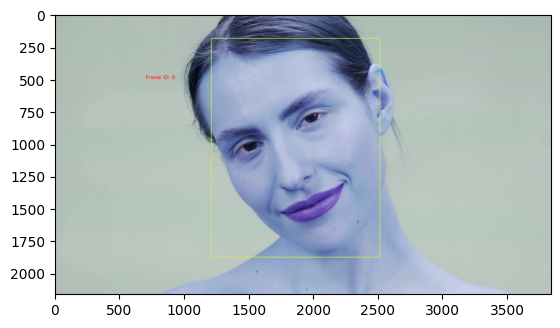

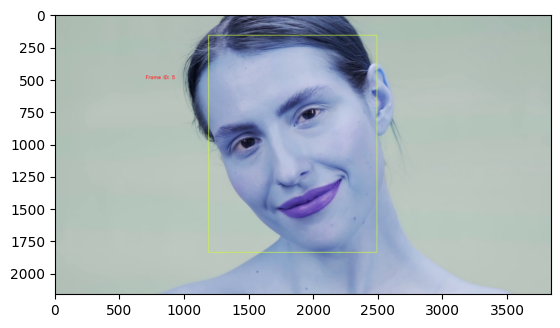

In [9]:
from ipywidgets import Video, Image
input_path = 'face.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)

In [ ]:
cursor.query("DROP FUNCTION FaceDetector").df()

,0
0,Function FaceDetector successfully dropped
